In [1]:
!nvidia-smi

Thu Aug 31 22:30:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    57W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(0)

GPU device: NVIDIA RTX A6000


In [3]:
from torch import nn
import torchvision
from torchinfo import summary
import sys
sys.path.append('/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline')


/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT means the best available weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=34).to(device)
# pretrained_vit # uncomment for model output

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 34]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
image_path = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/"
train_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/train"
test_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/test"
val_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/val"

In [7]:
from src.components import data_setup
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224
BATCH_SIZE = 16

train_dataloader, test_dataloader , val_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir=test_dir,
    val_dir = val_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f4137727640>,
 ['closing_bottle',
  'closing_door_inside',
  'closing_door_outside',
  'closing_laptop',
  'drinking',
  'eating',
  'entering_car',
  'exiting_car',
  'fastening_seat_belt',
  'fetching_an_object',
  'interacting_with_phone',
  'looking_or_moving_around (e.g. searching)',
  'opening_backpack',
  'opening_bottle',
  'opening_door_inside',
  'opening_door_outside',
  'opening_laptop',
  'placing_an_object',
  'preparing_food',
  'pressing_automation_button',
  'putting_laptop_into_backpack',
  'putting_on_jacket',
  'putting_on_sunglasses',
  'reading_magazine',
  'reading_newspaper',
  'sitting_still',
  'taking_laptop_from_backpack',
  'taking_off_jacket',
  'taking_off_sunglasses',
  'talking_on_phone',
  'unfastening_seat_belt',
  'using_multimedia_display',
  'working_on_laptop',
  'writing'])

In [8]:
len(train_dataloader), len(test_dataloader), len(val_dataloader)

(16242, 5458, 3502)

In [9]:
for batch, (X,y) in enumerate(train_dataloader):
    print(X.shape)
    print(y.shape)
    print(batch)
    break

torch.Size([16, 3, 224, 224])
torch.Size([16])
0


In [10]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(5))

In [11]:
image_batch.shape , label_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [12]:
prediction_batch = pretrained_vit(image_batch.to(device))

In [13]:
prediction_batch

tensor([[-3.3823e-01, -1.3944e-01,  1.9841e-01, -2.2082e-03,  1.6604e-01,
          1.9137e-01,  1.4212e-02,  2.8932e-01,  1.8491e-01, -4.5210e-01,
          3.1502e-01, -3.0833e-02,  2.6182e-01,  4.0792e-01, -2.5679e-01,
         -6.3510e-01, -1.9307e-01,  2.6488e-01,  7.8594e-01,  1.1323e-01,
          3.9722e-01,  5.4986e-02, -2.2854e-02, -7.5764e-01, -1.3428e-01,
          1.6641e-01,  2.3289e-01,  2.4536e-01, -6.5978e-01,  2.7049e-02,
          2.2461e-01, -7.0097e-01, -2.8822e-01, -8.8643e-02],
        [-1.1944e-01, -2.7621e-01, -4.7507e-01,  4.9227e-01, -3.9636e-02,
          3.0402e-01,  1.5955e-01,  1.7257e-01,  5.4632e-01, -8.8927e-01,
         -1.8320e-01, -1.6292e-01,  1.4806e-01,  1.0376e-01, -3.6960e-01,
         -2.3488e-01, -7.4933e-01,  4.3568e-01,  3.1691e-01,  1.0064e-01,
          3.2737e-01,  9.1415e-02,  6.0325e-01, -4.4606e-01,  3.9232e-01,
          4.4761e-01,  9.8625e-02,  4.2648e-01, -6.3376e-01, -1.5384e-01,
         -2.8455e-03, -4.6938e-01, -1.8304e-01, -1

In [14]:
prediction_batch.shape

torch.Size([16, 34])

In [15]:
y_pred_class = torch.argmax(torch.softmax(prediction_batch, dim=1), dim=1)

In [16]:
y_pred_class

tensor([18, 22, 27, 17, 22, 17, 12, 18,  7, 18, 27,  8, 17, 24,  8, 27],
       device='cuda:0')

In [17]:
y_pred_class_2 = torch.tensor([33, 21, 23,  8, 10,  10,  5,  15, 25,  9, 23,  15, 32, 21, 23,  8]).to(device)

In [18]:
label_batch

tensor([ 5, 25, 17,  4, 23, 24, 31, 25,  4, 32,  3, 23, 31, 24, 25, 17])

# Now experimentation on Accuracy and Balanced accurcy through manual implementation, torchmetrics, sklearn

In [19]:
from torchmetrics.classification import MulticlassAccuracy
# Move tensors to the same device
prediction_batch = prediction_batch.to(device)
label_batch = label_batch.to(device)

# Create metric instance and move it to the same device
metric = MulticlassAccuracy(num_classes=34).to(device)

In [20]:
# Calculate the metric using the moved tensors
result = metric(prediction_batch, label_batch)

In [21]:
result

tensor(0.0333, device='cuda:0')

In [22]:
result_2 = metric(y_pred_class,label_batch)

In [23]:
result_2

tensor(0.0333, device='cuda:0')

# Metrics for : multiclass classification,
In multiclass classification, you have more than two classes, and each class has its own set of predictions and ground truth labels. To calculate metrics like accuracy, precision, recall, and F1-score, which are typically designed for binary classification, you need to extend these metrics to handle multiple classes. This is where different averaging methods come into play.

* Macro Average:

The macro average calculates the metric independently for each class and then takes the average across all classes.
It treats all classes equally, regardless of their support (number of samples in each class).
Useful when you want to evaluate the model's performance across all classes equally and give each class the same importance.
The formula for macro average is: sum of class metric scores / number of classes.

* Micro Average:

The micro average aggregates the contributions of all classes to calculate the metric.
It's suitable when you want to give equal weight to each prediction, regardless of class, and evaluate the overall performance of the model.
Micro averaging essentially treats the entire multiclass problem as a binary problem by considering all predictions and ground truth labels together.
The formula for micro average depends on the metric but generally involves aggregating true positives, false positives, false negatives, etc., across all classes.

* Weighted Average:

The weighted average takes the same approach as the macro average, but it considers class support (number of samples in each class) during averaging.
It gives more weight to classes with higher support, reflecting their importance in the dataset.
This is useful when you want to balance the influence of classes with different numbers of samples.
The formula for weighted average is: sum of (class metric score * class support) / total support.

* In summary:

* Macro Average treats all classes equally, useful when you want a balanced evaluation across all classes.
* Micro Average treats all predictions equally, giving more importance to overall performance, often used for imbalanced datasets.
* Weighted Average gives more importance to classes with higher support, providing a balance between macro and micro averages.

In [24]:
from torchmetrics.classification import MulticlassAccuracy, Accuracy
# Move tensors to the same device
prediction_batch = torch.tensor([33, 21, 23,  8, 10,  10,  5,  15, 25,  9, 23,  15, 32, 21, 23,  8])
label_batch = torch.tensor([33, 21, 25,  8, 10,  0,  5,  5, 25,  9, 23,  5, 32, 21, 23,  8])
prediction_batch = prediction_batch.to(device)
label_batch = label_batch.to(device)

metric = Accuracy(task="multiclass", num_classes=34).to(device)
# Create metric instance and move it to the same device
result_1 = metric(prediction_batch,label_batch)
print(result_1)

# Micro is identical to manual implementation
metric_2 = MulticlassAccuracy(num_classes=34, average="micro").to(device)
result_2 = metric_2(prediction_batch,label_batch)
print(result_2)

tensor(0.7500, device='cuda:0')
tensor(0.7500, device='cuda:0')


In [25]:
from torchmetrics.classification import MulticlassConfusionMatrix
# Move tensors to the same device
prediction_batch = torch.tensor([33, 21, 23,  8, 10,  10,  5,  15, 25,  9, 23,  15, 32, 21, 23,  8])
label_batch = torch.tensor([33, 21, 25,  8, 10,  0,  5,  5, 25,  9, 23,  5, 32, 21, 23,  8])
prediction_batch = prediction_batch.to(device)
label_batch = label_batch.to(device)

metric = MulticlassConfusionMatrix(num_classes=34).to(device)
# Create metric instance and move it to the same device
result_CM_1 = metric(prediction_batch,label_batch)
print(result_CM_1)


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], device='cuda:0')


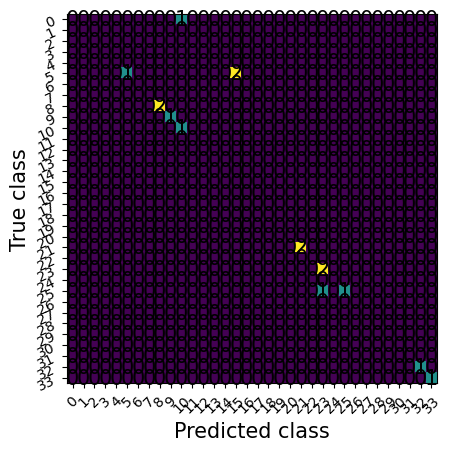

In [26]:
metric = MulticlassConfusionMatrix(num_classes=34).to(device)
result_CM_1 = metric(prediction_batch,label_batch)
fig_, ax_ = metric.plot(val=result_CM_1)

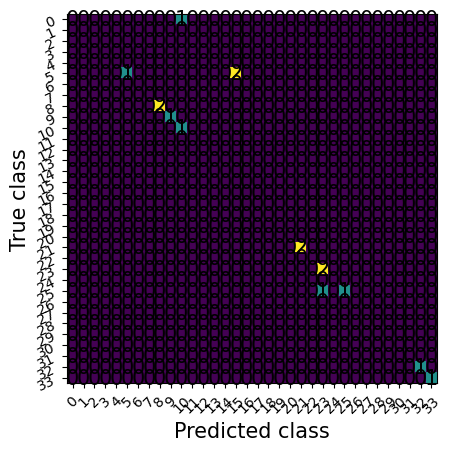

In [27]:
fig_

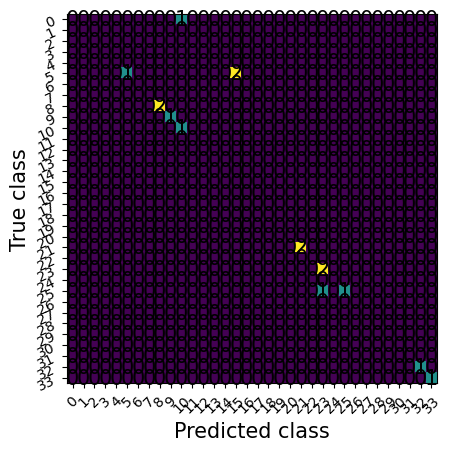

In [28]:
metric = MulticlassConfusionMatrix(num_classes=34).to(device)
metric.update(prediction_batch,label_batch)
fig_ , ax_ = metric.plot()
fig_ 

In [29]:
from torchmetrics.classification import ConfusionMatrix
confmat = ConfusionMatrix(task="multiclass", num_classes = 34).to(device)
confmat(prediction_batch, label_batch)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], device='cuda:0')

In [30]:
import torch

# Given data
prediction_batch = torch.tensor([33, 21, 23, 8, 10, 10, 5, 15, 25, 9, 23, 15, 32, 21, 23, 8])
y_batch = torch.tensor([33, 21, 25, 8, 10, 0, 5, 5, 25, 9, 23, 5, 32, 21, 23, 8])

num_classes = 34

# Initialize variables to store aggregated metrics
total_TP = 0
total_TN = 0
total_FP = 0
total_FN = 0

for i in range(num_classes):
    TP = torch.sum((prediction_batch == y_batch) & (y_batch == i))
    TN = torch.sum((prediction_batch != i) & (y_batch != i))
    FP = torch.sum((prediction_batch == i) & (y_batch != i))
    FN = torch.sum((prediction_batch != y_batch) & (y_batch == i))
    
    total_TP += TP
    total_TN += TN
    total_FP += FP
    total_FN += FN

# Calculate overall metrics
accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)
specificity = total_TN / (total_TN + total_FP)
sensitivity = total_TP / (total_TP + total_FN)

# Print the results
print(f"Overall True Positives (TP): {total_TP.item()}")
print(f"Overall True Negatives (TN): {total_TN.item()}")
print(f"Overall False Positives (FP): {total_FP.item()}")
print(f"Overall False Negatives (FN): {total_FN.item()}")
print(f"Overall Accuracy: {accuracy.item():.4f}")
print(f"Overall Specificity: {specificity.item():.4f}")
print(f"Overall Sensitivity: {sensitivity.item():.4f}")


Overall True Positives (TP): 12
Overall True Negatives (TN): 524
Overall False Positives (FP): 4
Overall False Negatives (FN): 4
Overall Accuracy: 0.9853
Overall Specificity: 0.9924
Overall Sensitivity: 0.7500


In [31]:
# Given data
prediction_batch_1 = torch.tensor([33, 21, 23, 8, 10, 10, 5, 15, 25, 9, 23, 15, 32, 21, 23, 8])
prediction_batch_2 = torch.tensor([1, 2, 32, 31,  3, 17,  9,  3, 12, 32, 26, 20, 13, 23,  2,  7])
prediction_batch_3 = torch.tensor([31,  3,  3, 15, 13, 28,  5, 18,  5, 24, 19, 29, 10,  4, 32, 26])
prediction_batch_4 = torch.tensor([ 7,  7,  0,  1, 26,  4, 16, 10, 26, 12, 14,  4,  8, 26,  0, 16])
prediction_batch_5 = torch.tensor([6, 11, 23, 8, 10, 22, 5, 15, 27, 9, 23, 15, 30, 21, 23, 8])


y_batch_1 = torch.tensor([33, 21, 25, 8, 10, 11, 5, 5, 25, 9, 23, 5, 32, 21, 23, 8])
y_batch_2 = torch.tensor([1, 22, 32, 3,  13, 7,  9,  13, 2, 32, 6, 0, 13, 23,  2,  7])
y_batch_3 = torch.tensor([1,  3,  13, 15, 13, 8,  5, 18,  5, 4, 19, 29, 10,  4, 20, 26])
y_batch_4 = torch.tensor([ 7,  17,  0,  1, 26,  14, 16, 10, 6, 12, 14,  4,  18, 26,  0, 16])
y_batch_5 = torch.tensor([31, 21, 24, 8, 20, 10, 5, 15, 27, 28, 23, 15, 30, 21, 23, 8])


In [32]:
y_true_all = [y_batch_1, y_batch_2, y_batch_3, y_batch_4,y_batch_5]
y_pred_all = [prediction_batch_1,prediction_batch_2,prediction_batch_3,prediction_batch_4,prediction_batch_5]

y_true_all = torch.concatenate(y_true_all)
y_pred_all = torch.concatenate(y_pred_all)

In [37]:
y_true_all

tensor([33, 21, 25,  8, 10, 11,  5,  5, 25,  9, 23,  5, 32, 21, 23,  8,  1, 22,
        32,  3, 13,  7,  9, 13,  2, 32,  6,  0, 13, 23,  2,  7,  1,  3, 13, 15,
        13,  8,  5, 18,  5,  4, 19, 29, 10,  4, 20, 26,  7, 17,  0,  1, 26, 14,
        16, 10,  6, 12, 14,  4, 18, 26,  0, 16, 31, 21, 24,  8, 20, 10,  5, 15,
        27, 28, 23, 15, 30, 21, 23,  8])

In [ ]:
torch.unique(y_true_all)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [ ]:
torch.unique(y_pred_all)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [ ]:
len(torch.unique(y_true_all))


34

In [ ]:
len(torch.unique(y_pred_all))

34

In [ ]:
import torch

def compute_balanced_accuracy(class_names, y_true_all, y_pred_all):
    num_classes = len(class_names)
    tp = torch.zeros(num_classes)
    tn = torch.zeros(num_classes)
    fp = torch.zeros(num_classes)
    fn = torch.zeros(num_classes)

    for y_true_batch, y_pred_batch in zip(y_true_all, y_pred_all):
        for class_idx in range(num_classes):
            class_mask = y_true_batch == class_idx
            tp[class_idx] += torch.sum(y_pred_batch[class_mask] == class_idx)
            tn[class_idx] += torch.sum(y_pred_batch[class_mask] != class_idx)
            fp[class_idx] += torch.sum(y_pred_batch[~class_mask] == class_idx)
            fn[class_idx] += torch.sum(y_pred_batch[~class_mask] != class_idx)

    balanced_acc = (tp + tn) / (tp + tn + fp + fn + torch.finfo(torch.float32).eps)
    avg_balanced_acc = torch.mean(balanced_acc)

    return balanced_acc, avg_balanced_acc

In [ ]:
balanced_acc, avg_balanced_acc = compute_balanced_accuracy(class_names, y_true_all, y_pred_all)

for class_idx, class_name in enumerate(class_names):
    print(f"Balanced Accuracy for class '{class_name}': {balanced_acc[class_idx]:.4f}")

print(f"Average Balanced Accuracy: {avg_balanced_acc:.4f}")

Balanced Accuracy for class 'closing_bottle': 0.0375
Balanced Accuracy for class 'closing_door_inside': 0.0375
Balanced Accuracy for class 'closing_door_outside': 0.0250
Balanced Accuracy for class 'closing_laptop': 0.0250
Balanced Accuracy for class 'drinking': 0.0375
Balanced Accuracy for class 'eating': 0.0750
Balanced Accuracy for class 'entering_car': 0.0250
Balanced Accuracy for class 'exiting_car': 0.0375
Balanced Accuracy for class 'fastening_seat_belt': 0.0625
Balanced Accuracy for class 'fetching_an_object': 0.0250
Balanced Accuracy for class 'interacting_with_phone': 0.0500
Balanced Accuracy for class 'looking_or_moving_around (e.g. searching)': 0.0125
Balanced Accuracy for class 'opening_backpack': 0.0125
Balanced Accuracy for class 'opening_bottle': 0.0625
Balanced Accuracy for class 'opening_door_inside': 0.0250
Balanced Accuracy for class 'opening_door_outside': 0.0375
Balanced Accuracy for class 'opening_laptop': 0.0250
Balanced Accuracy for class 'placing_an_object': 0

In [ ]:
import torch

def confusion_matrix(class_names, y_true_all, y_pred_all):
    num_classes = len(class_names)
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int)

    for y_true_batch, y_pred_batch in zip(y_true_all, y_pred_all):
        for true_class, pred_class in zip(y_true_batch, y_pred_batch):
            conf_matrix[true_class, pred_class] += 1

    return conf_matrix

# Example usage
class_names = class_names
y_true_all = [y_batch_1, y_batch_2, y_batch_3, y_batch_4,y_batch_5]
y_pred_all = [prediction_batch_1,prediction_batch_2,prediction_batch_3,prediction_batch_4,prediction_batch_5]

conf_matrix = confusion_matrix(class_names, y_true_all, y_pred_all)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
tensor([[2, 0, 0,  ..., 0, 0, 0],
        [0, 2, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 3, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)


In [ ]:
conf_matrix.shape

torch.Size([34, 34])

In [ ]:
conf_matrix.max() / 2

tensor(2.5000)

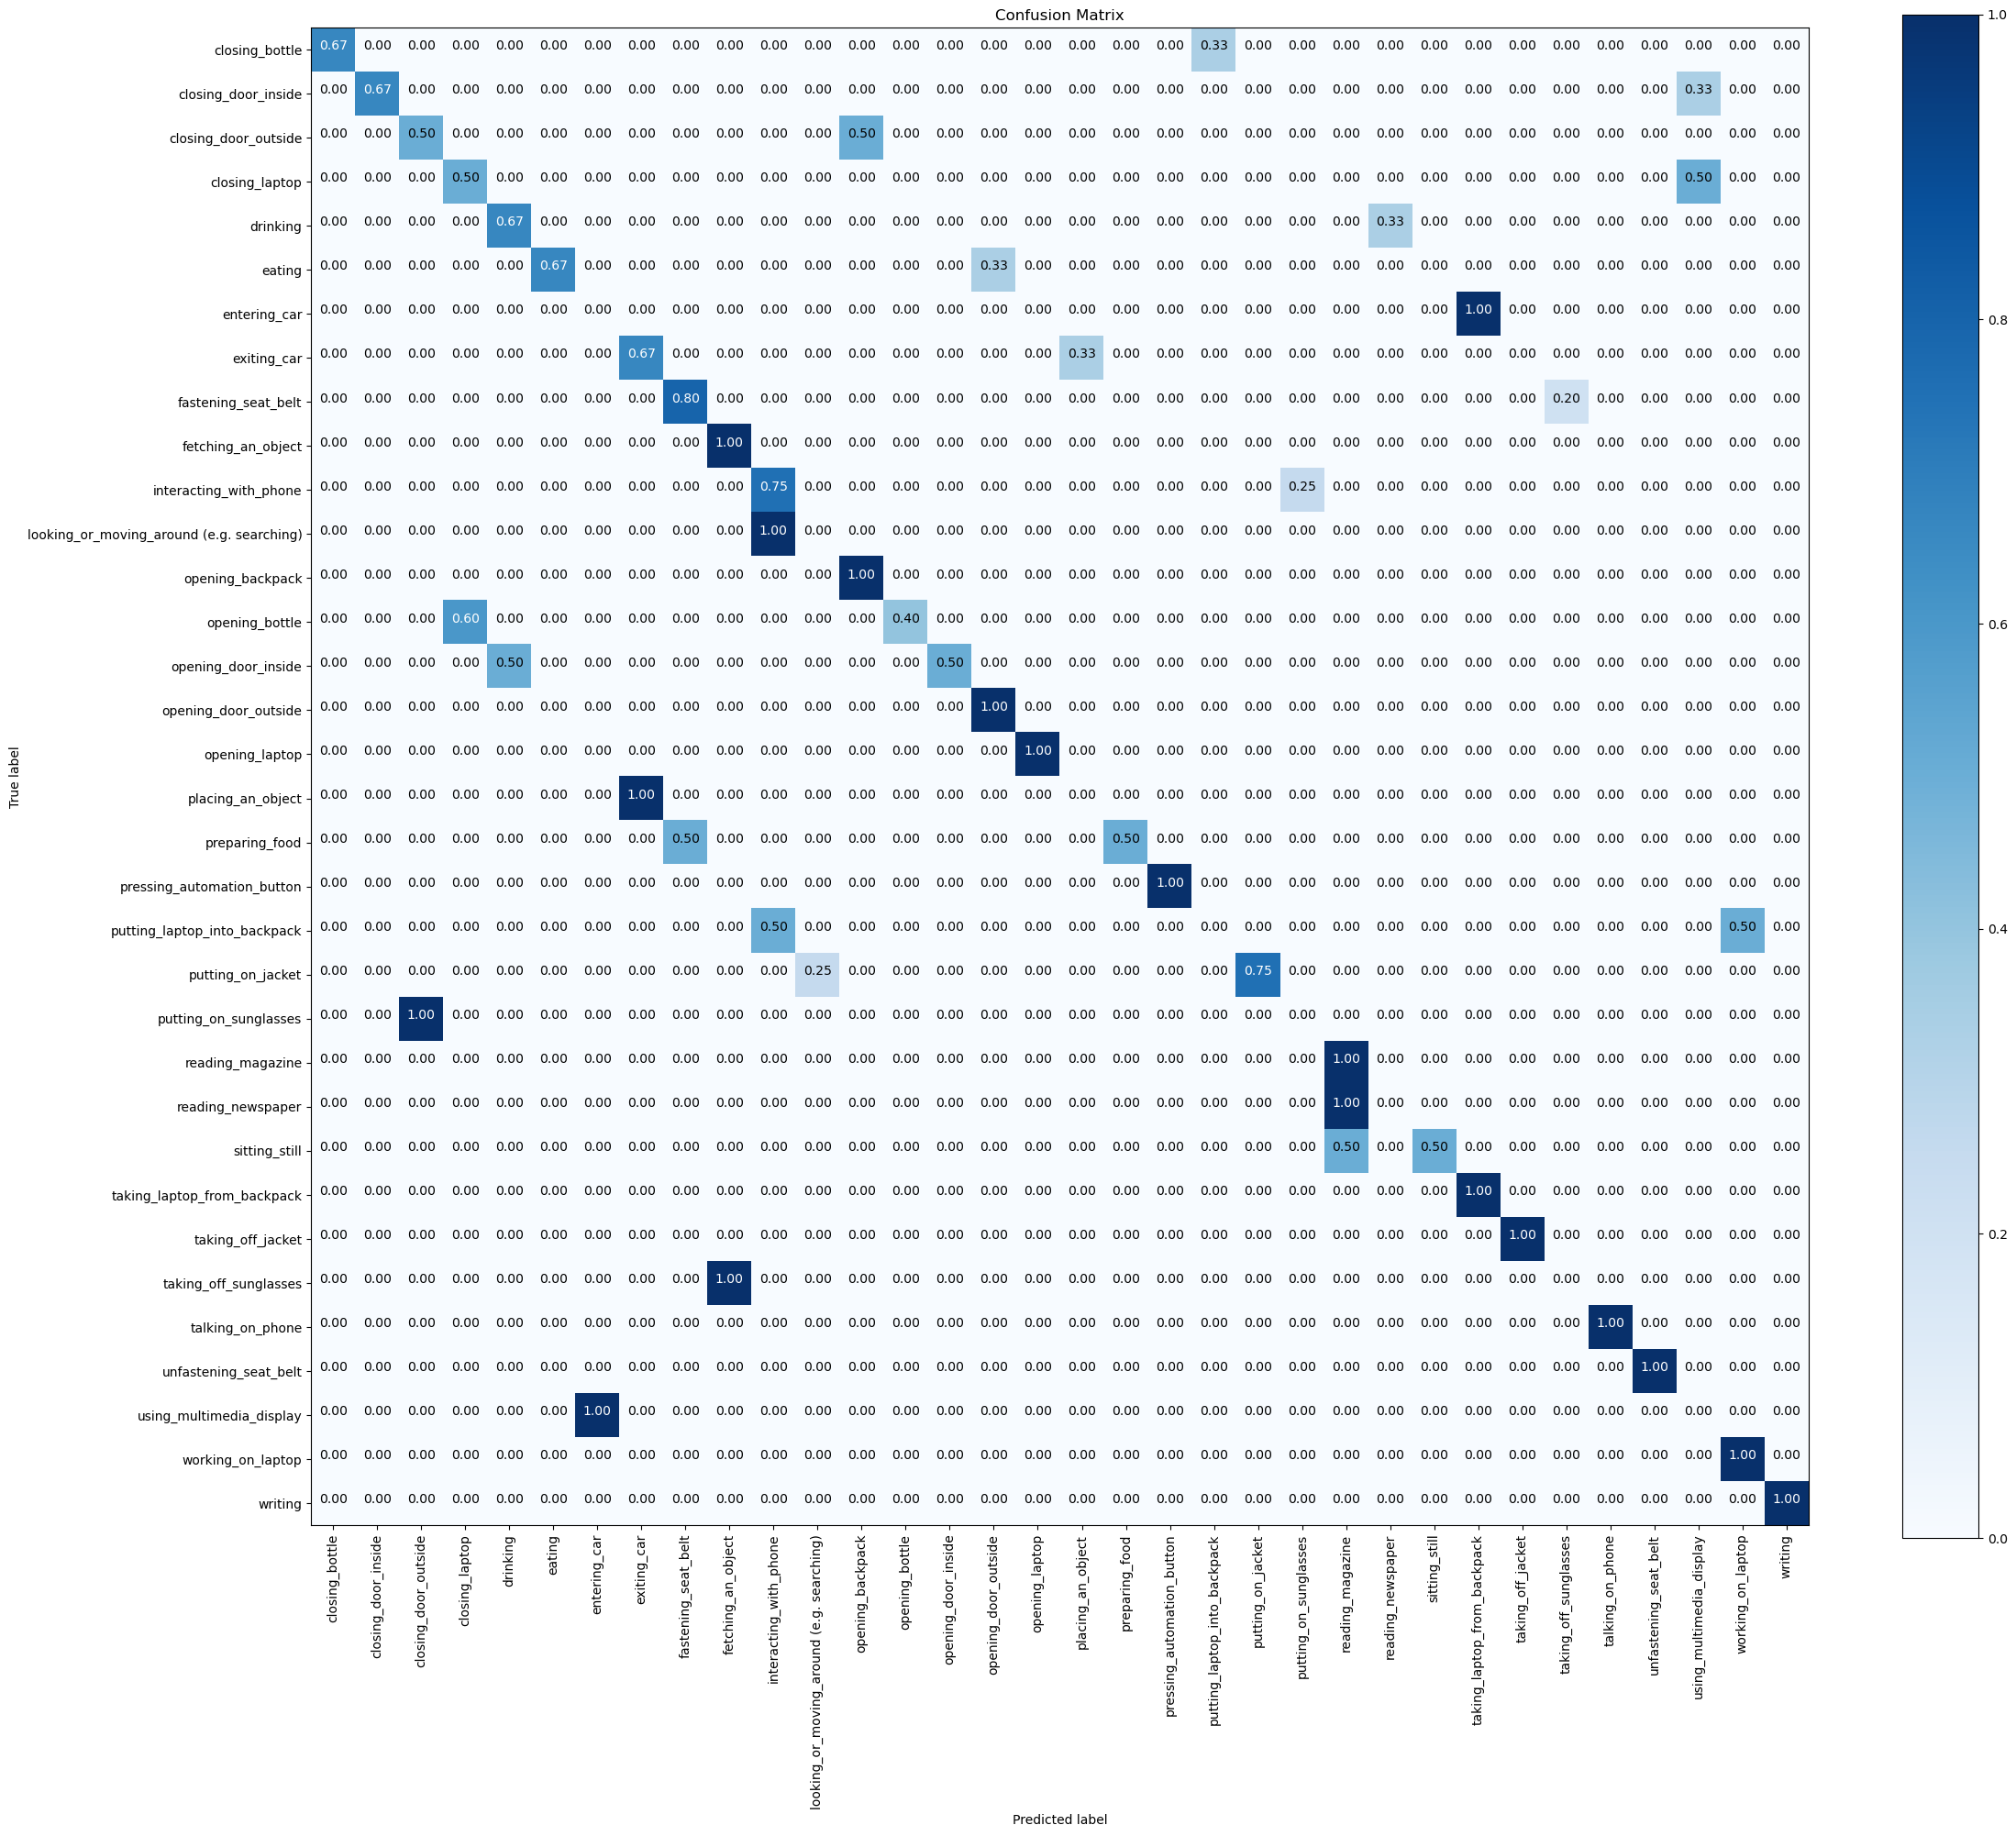

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(conf_matrix, class_names, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(8, 6)):
    if normalize:
        conf_matrix = conf_matrix.float() / conf_matrix.sum(dim=1, keepdim=True)

    plt.figure(figsize=figsize)  # Increase the figsize parameter here
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = torch.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt), horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

conf_matrix = conf_matrix
plot_confusion_matrix(conf_matrix, class_names, normalize=True, figsize=(24, 20))
